In [1]:
# Authors: Eric Wang & Xueru Xie

In [2]:
!pip3 install fastfuels==0.5.3
!pip3 install s3fs==0.5.2 
!pip3 install fsspec==0.8.3 

In [3]:
import fastfuels
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import rasterio
import rasterio.mask
from shapely import geometry
import geopandas as gpd
from fiona import crs

In [5]:
from scipy import stats

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
#src=rasterio.open(r'LF2021_FBFM40_210_CONUS/LF2021_FBFM40_210_CONUS/Tif/LC21_F40_210.tif')
src=rasterio.open('LC21_F40_210.tif')

print(type(src))
print(src.block_shapes)
display(src.files)
print(src.is_tiled)

<class 'rasterio.io.DatasetReader'>
[(128, 128)]


['LC21_F40_210.tif']

True


In [8]:
#original numbers:
# minx, miny = -122.0003, 45
# maxx, maxy = -122, 45.0003

minx, miny = -121.806464, 38.126339
maxx, maxy = -121.806164, 38.126639

bbox = geometry.box(minx, miny, maxx, maxy)

geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=crs.from_epsg(4326))  #Word Geodetic System 1984

print(geo)

                                            geometry
0  POLYGON ((-121.80616 38.12634, -121.80616 38.1...


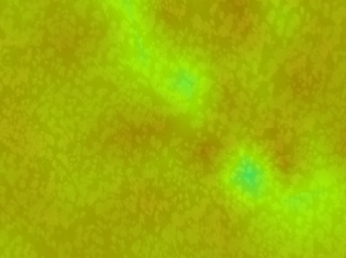
<div align="center">(Forest area with fastfuels sav layered over)<div>

                                            geometry
0  POLYGON ((-2213370.933 1979364.929, -2213361.9...


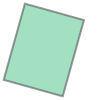

In [9]:
geo_utm=geo.to_crs(crs=src.crs.data)
print(geo_utm)
display(geo_utm.loc[0,"geometry"])

In [10]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]
coords=getFeatures(geo_utm)
display(coords)

[{'type': 'Polygon',
  'coordinates': [[[-2213370.9326172518, 1979364.9285774315],
    [-2213361.9134944724, 1979397.321777114],
    [-2213387.008522878, 1979404.3089388362],
    [-2213396.0277479156, 1979371.9157676257],
    [-2213370.9326172518, 1979364.9285774315]]]}]

In [11]:
out_img, out_transform = rasterio.mask.mask(src, shapes=coords, crop=True)

In [12]:
print(np.unique(out_img))

[  102 32767]


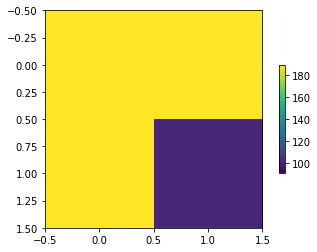

In [13]:
fig,ax=plt.subplots()

h=ax.imshow(out_img[0,:,:], origin="upper", vmin=91., vmax=189.)
fig.colorbar(h, shrink=0.5)

Mapped data values align with the fastfuels classification of TL5, High load conifer litter, light slash or dead fuel, spread rate and flame low.

In [14]:
fio = fastfuels.open('https://wifire-data.sdsc.edu:9000/fastfuels/index.fio', ftype='s3', username='fastfuels', password='Treatment##Buffet')
fio.cache_limit = 1e14

Bounding box query found in single source: or_set/or_38.fio


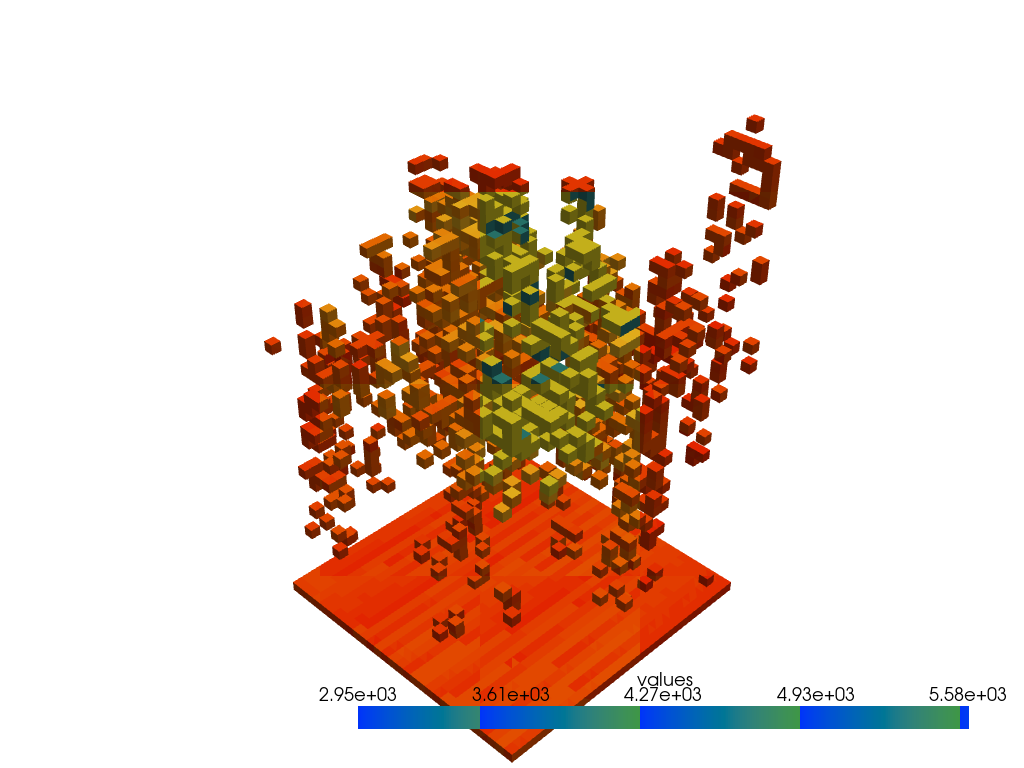

In [15]:
roi = fio.query(-122.0003, 45, 15)
roi.view('sav')

In [16]:
print(roi.get_properties())

['bulk_density', 'sav', 'moisture', 'fuel_depth', 'elevation']


In [17]:
# roi = fio.query(minx, miny, 30)
# roi.view('bulk_density')

In [18]:
raw_sav_data = roi.data_dict['sav']
raw_moisture_data = roi.data_dict['moisture']
raw_elevation_data = roi.data_dict['elevation']

In [19]:
raw_sav_data.shape

(30, 30, 128)

In [20]:
pixels = []
for x in range(len(raw_sav_data)):
    for y in raw_sav_data[x]:
        avg = y.mean()
        pixels.append(avg)

In [21]:
import pandas as pd
df = pd.DataFrame()
df['Pix'] = pixels

<AxesSubplot:>

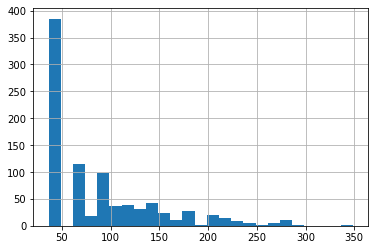

In [22]:
df['Pix'].hist(bins=25)

In [23]:
df[df['Pix']<50].shape[0]/df.shape[0]

0.42777777777777776

In [24]:
#helper function from above
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [37]:
def deez_nuts(long, lat):
    
    output = []

    minx, miny = lat, long
    maxx, maxy = lat + 0.0003, long + 0.0003

    bbox = geometry.box(minx, miny, maxx, maxy)

    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=crs.from_epsg(4326))  #Word Geodetic System 1984
    geo_utm=geo.to_crs(crs=src.crs.data)
    coords=getFeatures(geo_utm)
    out_img, out_transform = rasterio.mask.mask(src, shapes=coords, crop=True)
    
    output.append(np.unique(out_img)[0])
#    fig,ax=plt.subplots(1,2)

#    h=ax[0].imshow(out_img[0,:,:], origin="upper", vmin=91., vmax=189.)
    fig.colorbar(h, shrink=0.5)
    
    roi = fio.query(lat, long, 15)
#    print(roi.view('sav'))
    raw_sav_data = roi.data_dict['sav']
    
    pixels = []
    for x in range(len(raw_sav_data)):
        for y in raw_sav_data[x]:
            avg = sum(y)
            pixels.append(avg)
            
    df = pd.DataFrame()
    df['Pix'] = pixels
    print(df['Pix'].hist())
    
    output.append([sum(pixels)/len(pixels)])#(df[df['Pix'] < 20].shape[0] / df.shape[0] * 100)
    
    print('The label for this region is ' + str(output[0]))
    print('The sum of non-flat surface in this region is ' + str(output[1]))
    return output

Bounding box query found in single source: ca_set/ca_74.fio
AxesSubplot(0.125,0.125;0.775x0.755)
The label for this region is 102
The sum of non-flat surface in this region is [5960.78466796875]


[102, [5960.78466796875]]

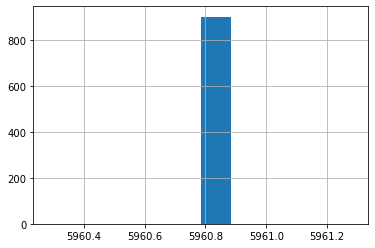

In [38]:
deez_nuts(38.126339, -121.806464) #grass

Bounding box query found in single source: ca_set/ca_238.fio
AxesSubplot(0.125,0.125;0.775x0.755)
The label for this region is 102
The sum of non-flat surface in this region is [5960.78466796875]


[102, [5960.78466796875]]

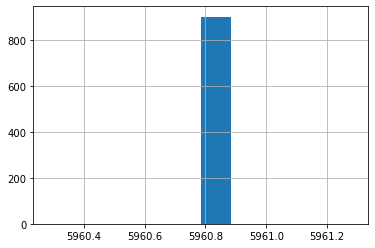

In [39]:
deez_nuts(32.938576, -116.684257) #grass

Bounding box query found in single source: ca_set/ca_237.fio
AxesSubplot(0.125,0.125;0.775x0.755)
The label for this region is 122
The sum of non-flat surface in this region is [5992.1572265625]


[122, [5992.1572265625]]

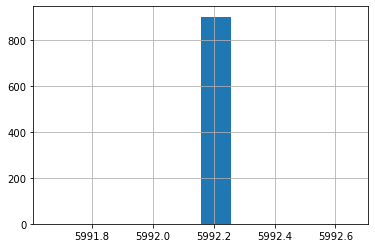

In [40]:
deez_nuts(32.885801, -116.873526) #grass shrub

Bounding box query found in single source: ca_set/ca_237.fio
AxesSubplot(0.125,0.125;0.775x0.755)
The label for this region is 91
The sum of non-flat surface in this region is [1.4291939883761935]


[91, [1.4291939883761935]]

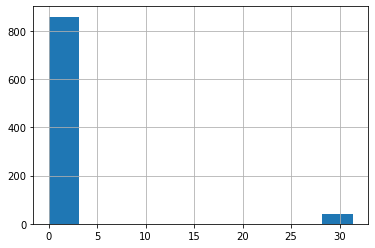

In [41]:
deez_nuts(32.783077, -116.953164) #urban

choosing ca_set/ca_84.fio
AxesSubplot(0.125,0.125;0.775x0.755)
The label for this region is 98
The sum of non-flat surface in this region is [0.0]


[98, [0.0]]

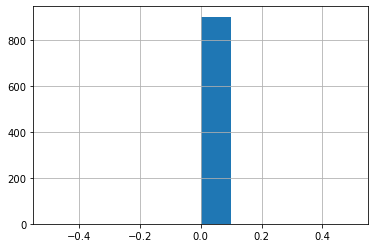

In [42]:
deez_nuts( 39.151537, -120.010631 ) #Lake Tahoe

Bounding box query found in single source: ca_set/ca_81.fio
AxesSubplot(0.125,0.125;0.775x0.755)
The label for this region is 186
The sum of non-flat surface in this region is [9873.952353786892]


[186, [9873.952353786892]]

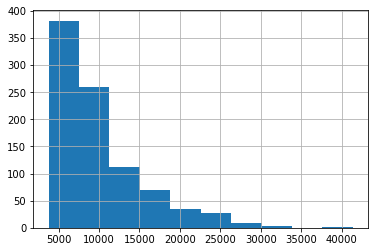

In [43]:
deez_nuts( 38.989042, -120.579882 ) #forest in Lake Tahoe

Bounding box query found in single source: ca_set/ca_183.fio
AxesSubplot(0.125,0.125;0.775x0.755)
The label for this region is 99
The sum of non-flat surface in this region is [1303.8780344984266]


[99, [1303.8780344984266]]

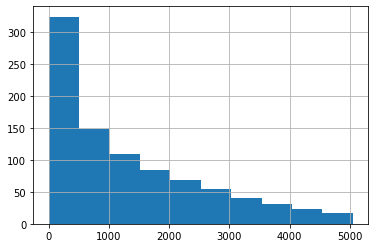

In [44]:
deez_nuts( 34.860323, -117.718669 ) #some desert place in California

Bounding box query found in single source: ca_set/ca_189.fio
AxesSubplot(0.125,0.125;0.775x0.755)
The label for this region is 99
The sum of non-flat surface in this region is [0.34858389960394964]


[99, [0.34858389960394964]]

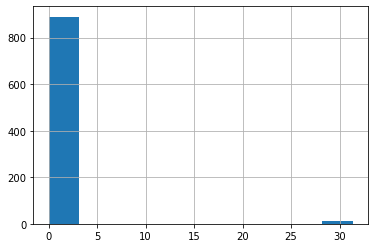

In [45]:
deez_nuts( 35.417153, -116.658997 ) #another desert place

Bounding box query found in single source: co_set/co_166.fio
AxesSubplot(0.125,0.125;0.775x0.755)
The label for this region is 165
The sum of non-flat surface in this region is [7836.131198459201]


[165, [7836.131198459201]]

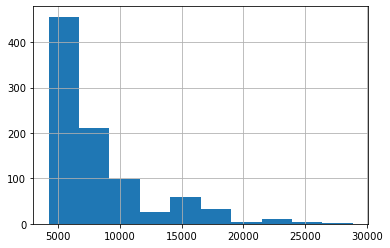

In [46]:
deez_nuts( 38.325022, -106.402827 ) #forest

Bounding box query found in single source: co_set/co_166.fio
AxesSubplot(0.125,0.125;0.775x0.755)
The label for this region is 32767
The sum of non-flat surface in this region is [8722.510104166666]


[32767, [8722.510104166666]]

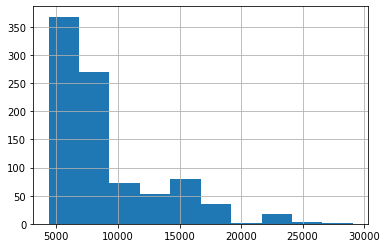

In [47]:
deez_nuts( 38.341057, -106.478022 ) #forest

Bounding box query found in single source: co_set/co_167.fio
AxesSubplot(0.125,0.125;0.775x0.755)
The label for this region is 142
The sum of non-flat surface in this region is [7938.754083658854]


[142, [7938.754083658854]]

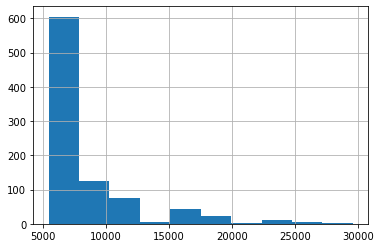

In [48]:
deez_nuts( 38.295717, -105.804288 ) #forest

Rough Summary

0 = Water

~1 = Urban

~1-1k = Desert (Depends on the amount of dry plants in a desert)

~6k = Grass/Shrub

~7k-10k = Forest